In [1]:
import pandas as pd
import ray
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import plotly.graph_objects as go
from itertools import combinations
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import (train_test_split, GridSearchCV,
                                    StratifiedKFold, StratifiedShuffleSplit,
                                    cross_val_score)
from sklearn.metrics import make_scorer, recall_score, precision_score, f1_score, classification_report
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import joblib


2023-10-23 10:44:42.598088: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-23 10:44:42.787344: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-23 10:44:42.787372: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-23 10:44:42.788774: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-23 10:44:42.898196: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-23 10:44:42.899648: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [2]:
def optimize_hyperparameters(X, y):
    # Initialize a BalancedRandomForestClassifier
    clf = RandomForestRegressor()

    # Define hyperparameters grid
    param_grid = {
        'n_estimators': [200,500,800],
        'max_features': ['sqrt', 'log2'],
        'max_depth': [10, 20, 30, None]    }

    # Grid search with cross-validation
    grid_search = GridSearchCV(estimator=RandomForestRegressor(),
                           param_grid=param_grid,
                           scoring='neg_mean_squared_error',  # For regression
                           cv=3,  # Number of cross-validation folds
                           verbose=2,
                           n_jobs=-1  # Use all available CPUs
                          ) 
    grid_search.fit(X, y)

    # Return best parameters and best score
    return grid_search

In [98]:
def plot_regression_results(Y_true, Y_pred, metalicidad, title, path='/home/marcelo/nico/data_Splus_parameters/result/'):
    """
    Create subplots of true vs predicted values for all features and save them as a PDF.

    Parameters:
    - Y_true (DataFrame): Actual values.
    - Y_pred (DataFrame): Predicted values.
    - title (str): Title for the entire set of subplots.
    """
    
    num_columns = len(Y_pred.columns)
    
    # Check if there is only one column, and create a single plot
    if num_columns == 1:
        fig, ax = plt.subplots(figsize=(8, 6))
        sc = ax.scatter(Y_pred, Y_true, cmap='viridis', c=metalicidad.values, alpha=0.5)
        ax.plot([Y_true.min(), Y_true.max()],
                [Y_true.min(), Y_true.max()],
                color='red', linestyle='--')
        ax.set_xlim(Y_pred[Y_pred.columns[0]].values.min(),Y_pred[Y_pred.columns[0]].values.max())
      #  ax.set_title(Y_true)
        ax.set_xlabel(f'Predicted {Y_pred.columns[0]}')
        ax.set_ylabel(f'True {Y_pred.columns[0]}')
        ax.grid(True)
        fig.colorbar(sc, ax=ax)
    else:
        # Calculate the number of rows needed based on the number of columns
        nrows = -(-num_columns // 2)  # This is a way to compute the ceiling of the division.

        # Setting up a grid for the subplots
        fig, axes = plt.subplots(nrows=nrows, ncols=2, figsize=(15, 20))
        fig.suptitle(title, fontsize=16)

        # Flattening the axes array for easy indexing
        axes = axes.ravel()

        # Plot data for each column
        for idx, column in enumerate(Y_true.columns):
            # X-axis: Predicted values, Y-axis: True values
            sc = axes[idx].scatter(Y_pred[column], Y_true[column], cmap='viridis', c=metalicidad, alpha=0.5)

            # Diagonal line
            axes[idx].plot([Y_true[column].min(), Y_true[column].max()],
                           [Y_true[column].min(), Y_true[column].max()],
                           color='red', linestyle='--')

            # Set x-axis limits
            axes[idx].set_xlim(Y_pred[column].min(), Y_pred[column].max())
            axes[idx].set_title(column)
            axes[idx].set_xlabel(f'Predicted {column}')
            axes[idx].set_ylabel(f'True {column}')
            axes[idx].grid(True)
            fig.colorbar(sc, ax=axes[idx])

        # Remove any unused subplots
        for i in range(num_columns, nrows * 2):
            fig.delaxes(axes[i])
    
    # Save the figure to a PDF file
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
    fig.savefig(f'{path}{title}.pdf')






In [4]:
def preprocess_features(data,columns,bad_values):
    """
    Realiza el preprocesamiento de las características especificadas.

    Args:
    - data (pd.DataFrame): DataFrame original con los datos.

    Returns:
    - data (pd.DataFrame): DataFrame procesado con características adicionales y filas inválidas eliminadas.
    """
    
    # Busca valores 999 o -999 en las columnas especificadas
    invalid_values = data[columns].isin([bad_values, -bad_values]).sum()

    # Filtra y muestra solo las columnas que tienen estos valores inválidos
    columns_with_invalids = invalid_values[invalid_values > 0]

    if columns_with_invalids.empty:
        print(f" Todas las columnas tienen datos válidos, sin valores {bad_values} o -{bad_values}.")
    else:
        print(f"Las siguientes columnas tienen valores {bad_values} o -{bad_values}:\n{columns_with_invalids}")

    # Filtra el DataFrame para excluir filas con valores 999 o -999 en las columnas especificadas
    data = data[~data[columns].isin([bad_values, -bad_values]).any(axis=1)].reset_index(drop=True)

    return data

In [5]:
file_names = [
    "Apogee-Colors-Dwarfs",
    "Galah-Colors-Giants",
    "Apogee-Colors-Giants",
    "LamostMedium-Colors-Dwarfs",
    "Galah-Colors-Dwarfs",
    "LamostMedium-Colors-Giants"
]


 Todas las columnas tienen datos válidos, sin valores 999 o -999.
 Todas las columnas tienen datos válidos, sin valores 9999 o -9999.
Las siguientes columnas tienen valores 0 o -0:
u-J378       27
u-J395       28
u-J410       16
u-J515        1
u-J660        3
u-J861        2
J378-J395    33
J378-J410    18
J378-J430     2
J378-J660     2
J378-J861     1
J395-J410    18
J395-J430     4
J395-J660     2
J395-J861     2
J410-J430     4
J410-J515     2
J410-J660     3
J410-J861     1
J430-J515     1
J430-J861     1
J515-J660     1
r-J660        3
r-i           1
r-J861        1
J660-i        2
J660-J861     2
i-J861        6
i-z           1
J861-z        5
dtype: int64
 Todas las columnas tienen datos válidos, sin valores 999 o -999.
 Todas las columnas tienen datos válidos, sin valores 9999 o -9999.
 Todas las columnas tienen datos válidos, sin valores 0 o -0.
Fitting 3 folds for each of 24 candidates, totalling 72 fits
 Todas las columnas tienen datos válidos, sin valores 999 o -999.
 To

/tmp/ipykernel_6755/123779475.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(8, 6))


 Todas las columnas tienen datos válidos, sin valores 999 o -999.
 Todas las columnas tienen datos válidos, sin valores 9999 o -9999.
 Todas las columnas tienen datos válidos, sin valores 0 o -0.
Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] END ..max_depth=10, max_features=sqrt, n_estimators=200; total time=   5.9s
[CV] END ..max_depth=20, max_features=sqrt, n_estimators=200; total time=   8.4s
[CV] END ..max_depth=20, max_features=log2, n_estimators=200; total time=   6.6s
[CV] END ..max_depth=20, max_features=log2, n_estimators=500; total time=  19.7s
[CV] END ..max_depth=30, max_features=log2, n_estimators=500; total time=  20.1s
[CV] END max_depth=None, max_features=sqrt, n_estimators=800; total time=  33.3s
[CV] END ..max_depth=10, max_features=log2, n_estimators=200; total time=   4.6s
[CV] END ..max_depth=10, max_features=log2, n_estimators=800; total time=  18.5s
[CV] END ..max_depth=20, max_features=log2, n_estimators=800; total time=  31.7s
[CV] END max_d

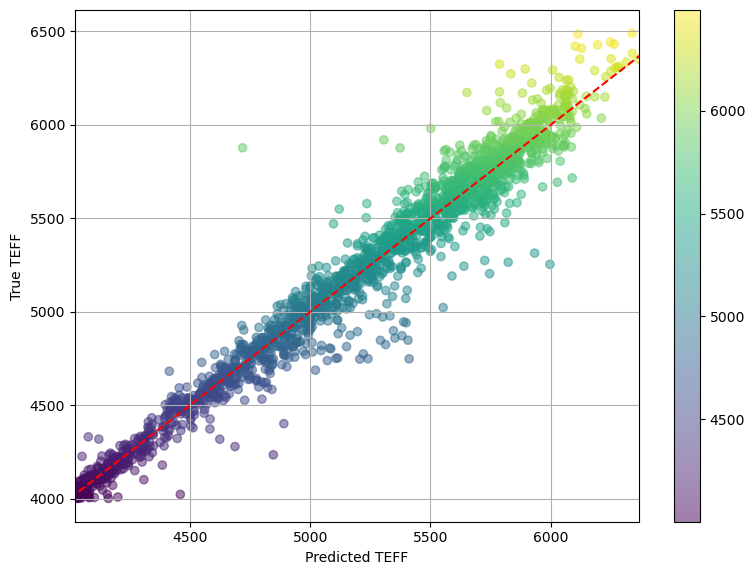

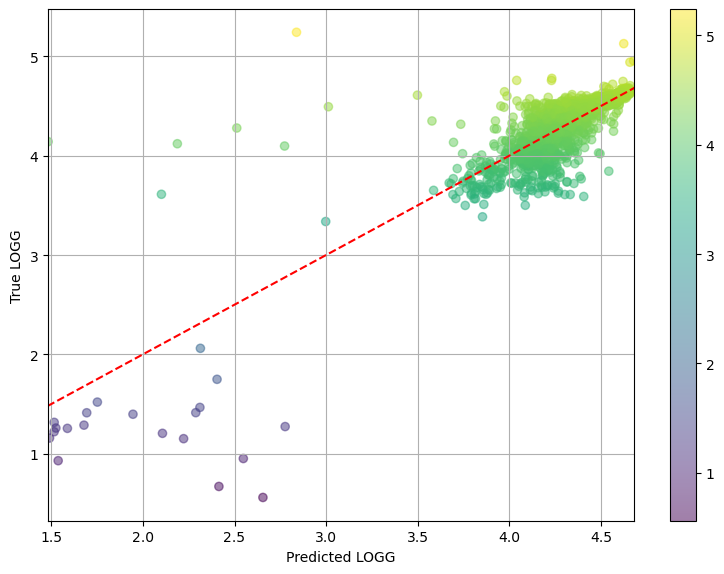

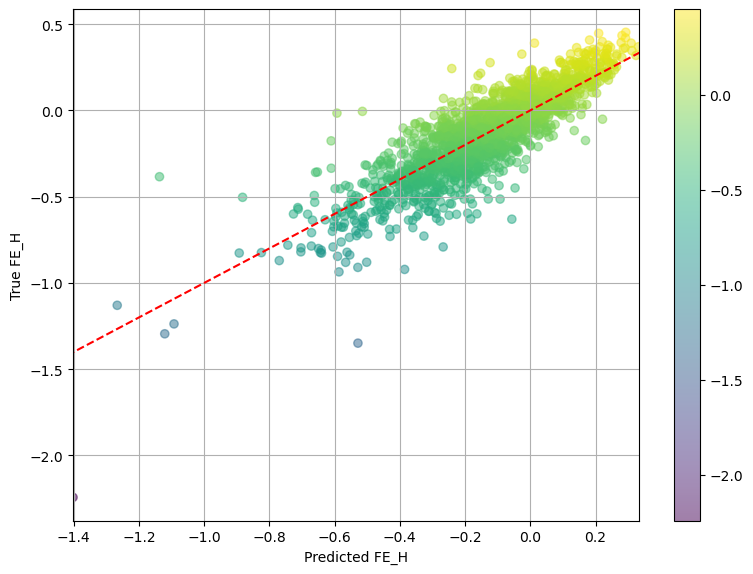

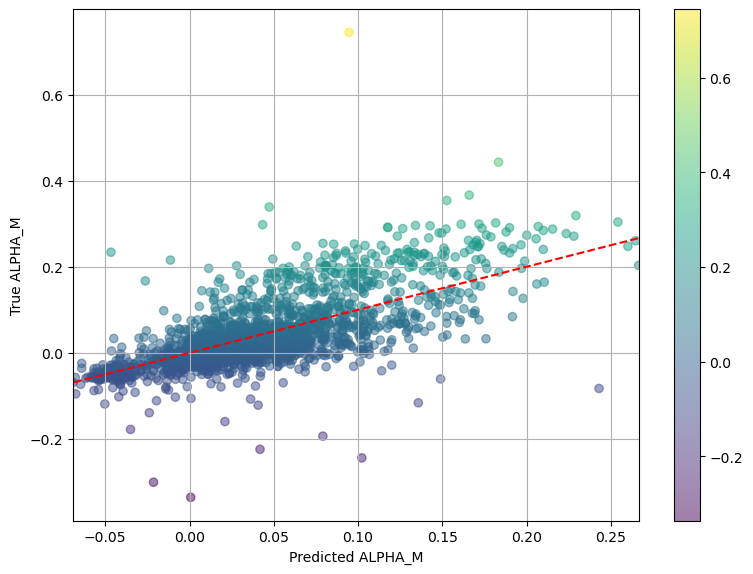

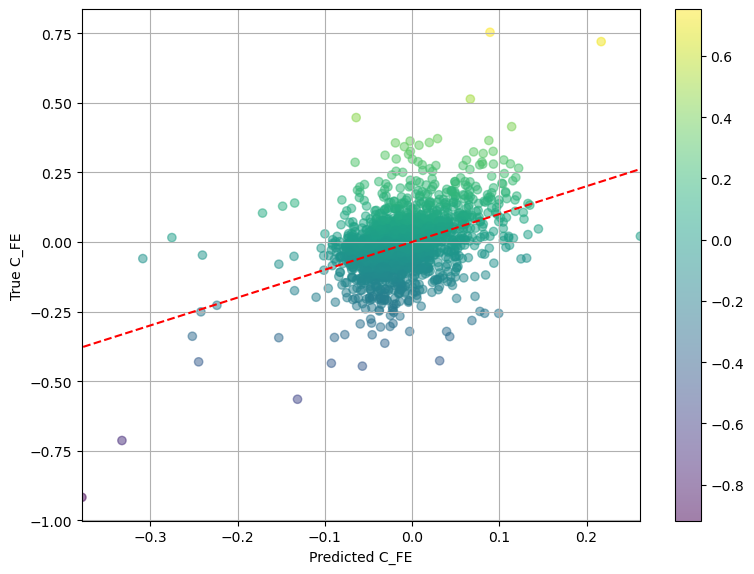

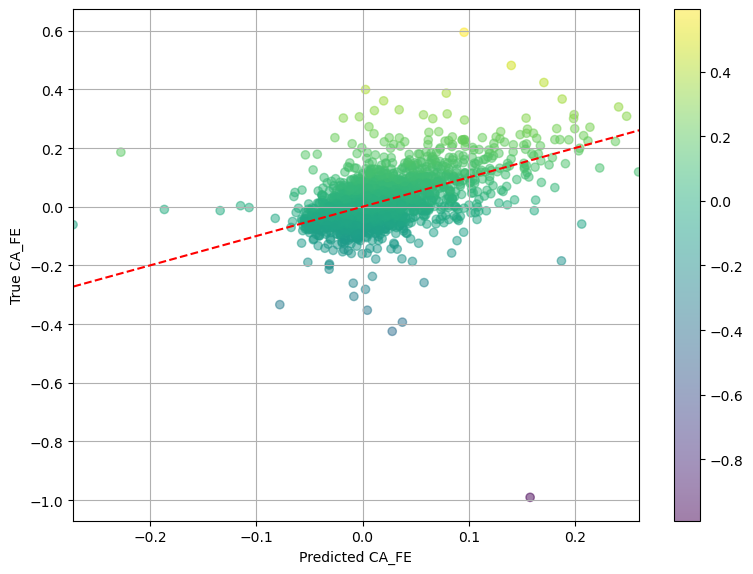

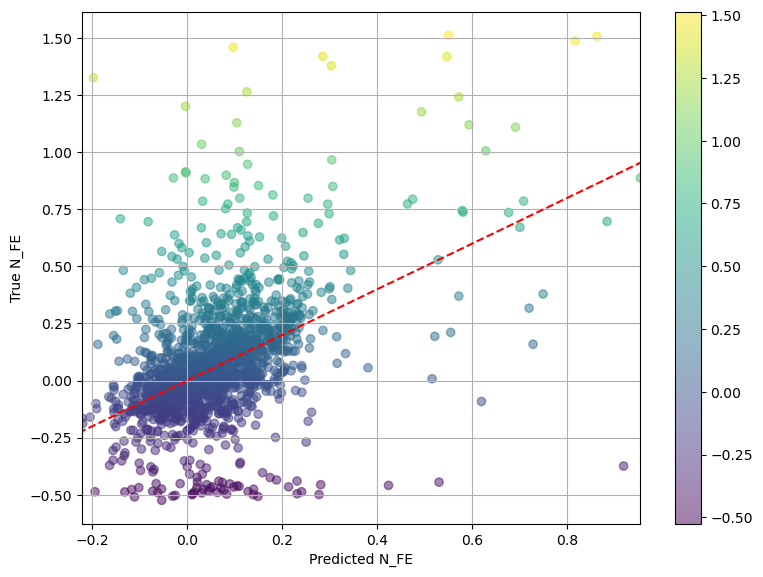

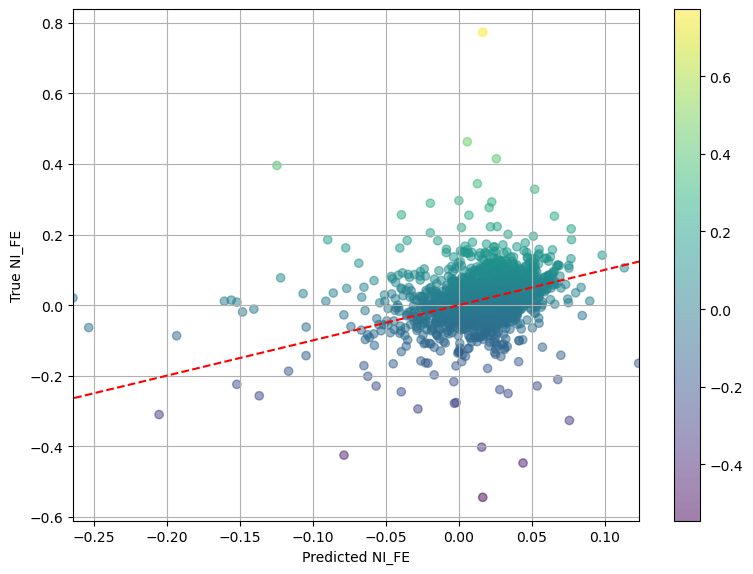

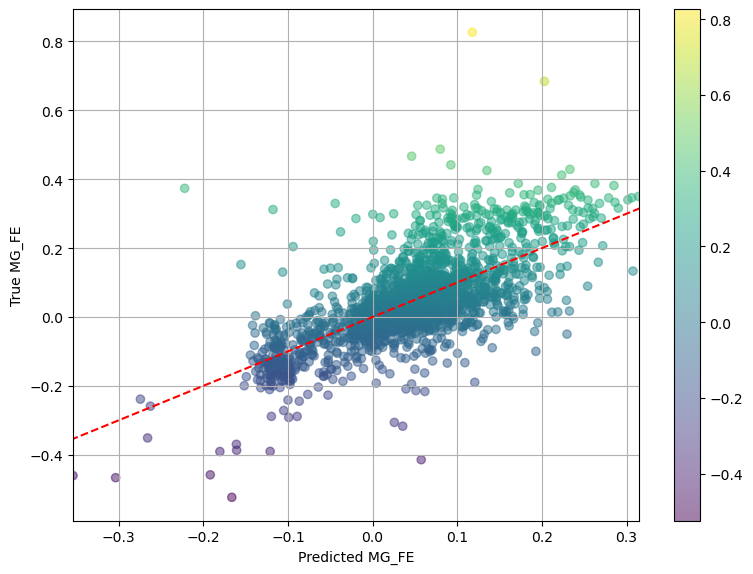

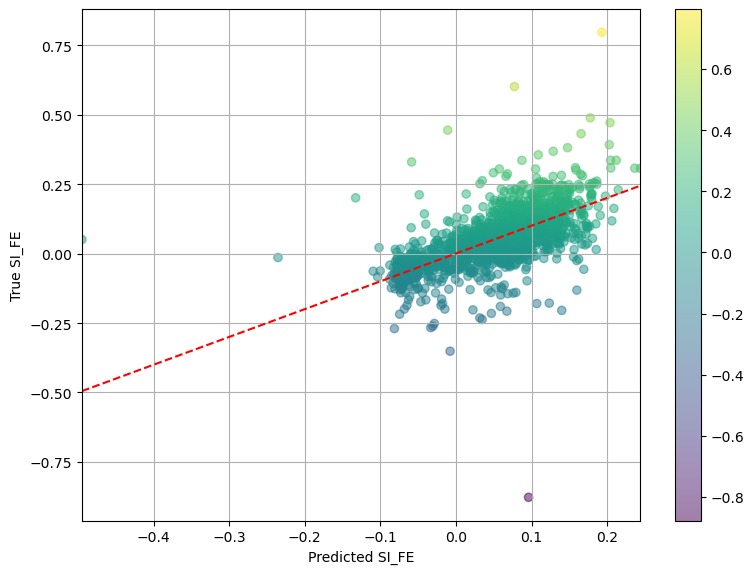

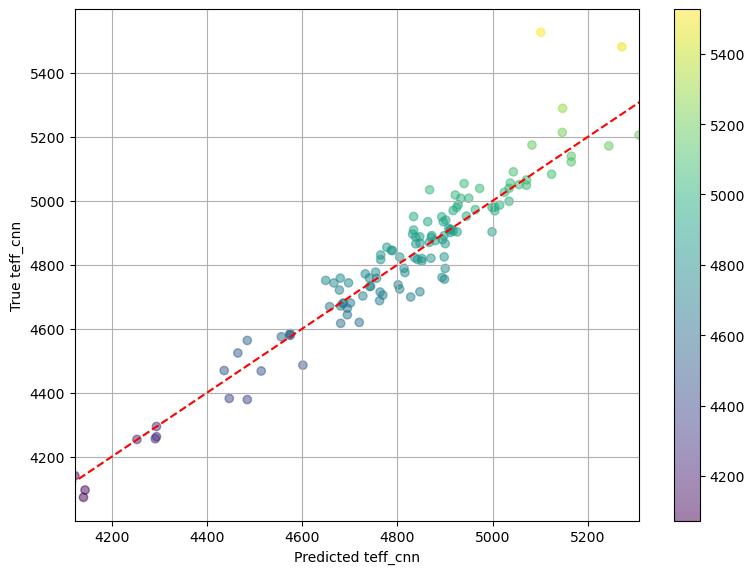

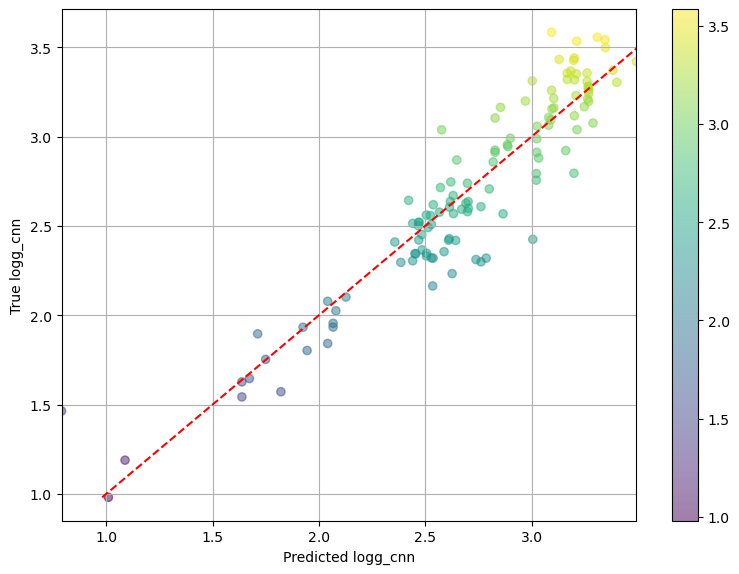

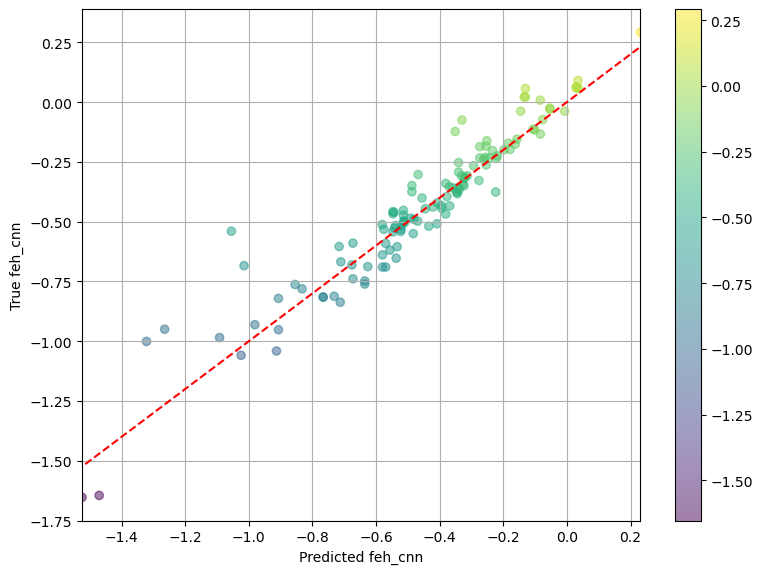

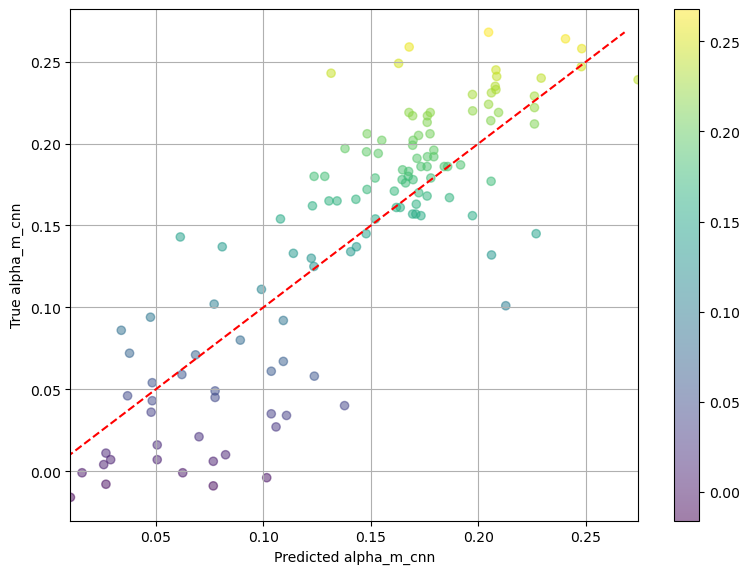

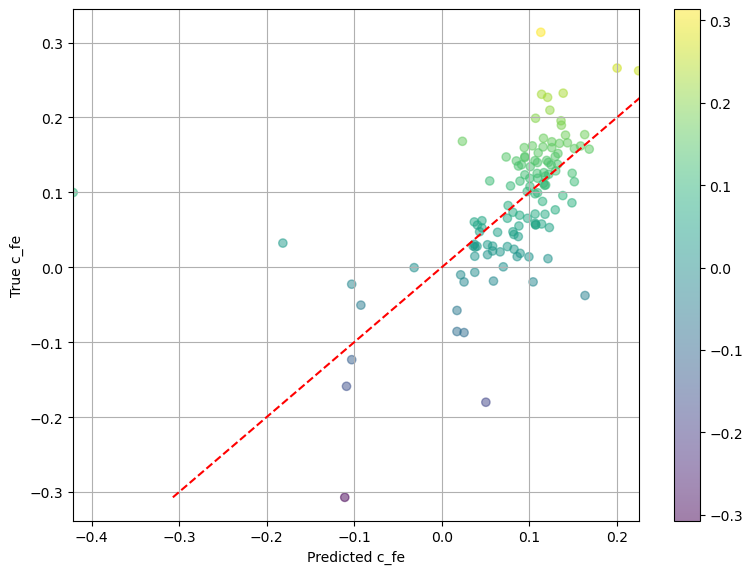

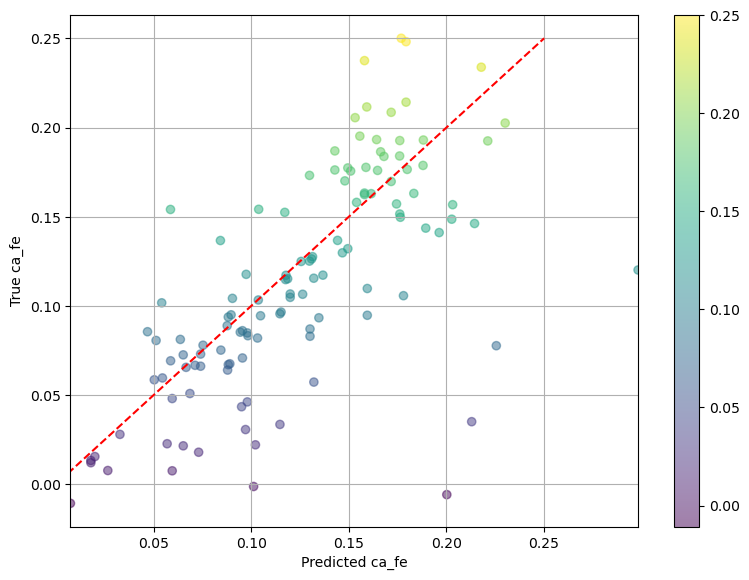

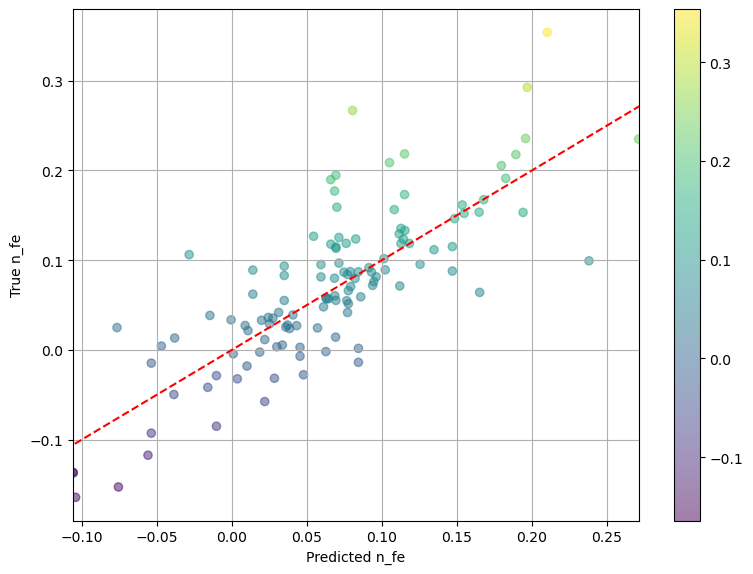

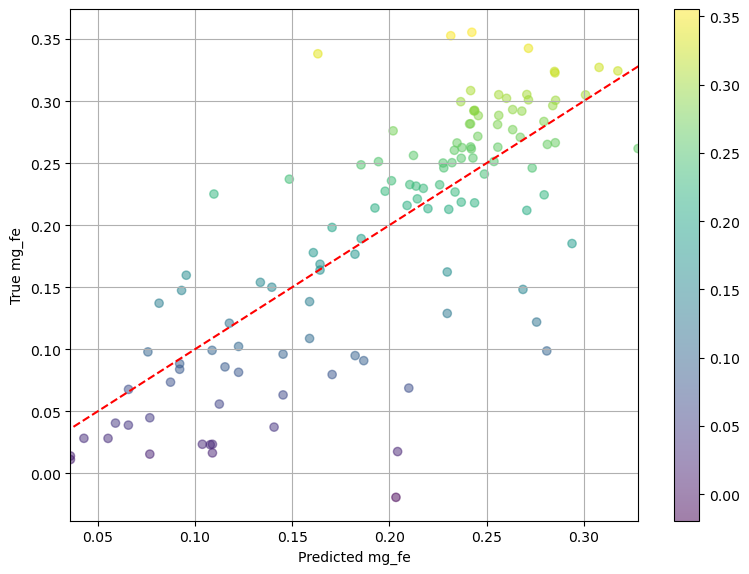

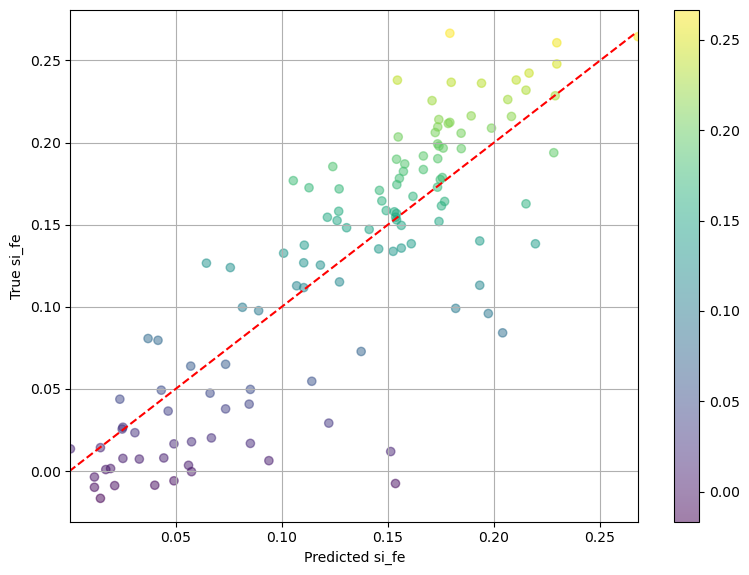

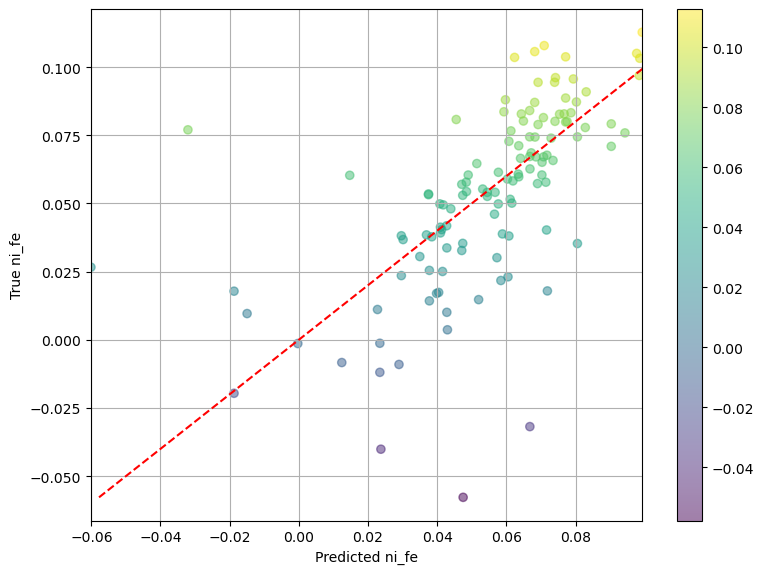

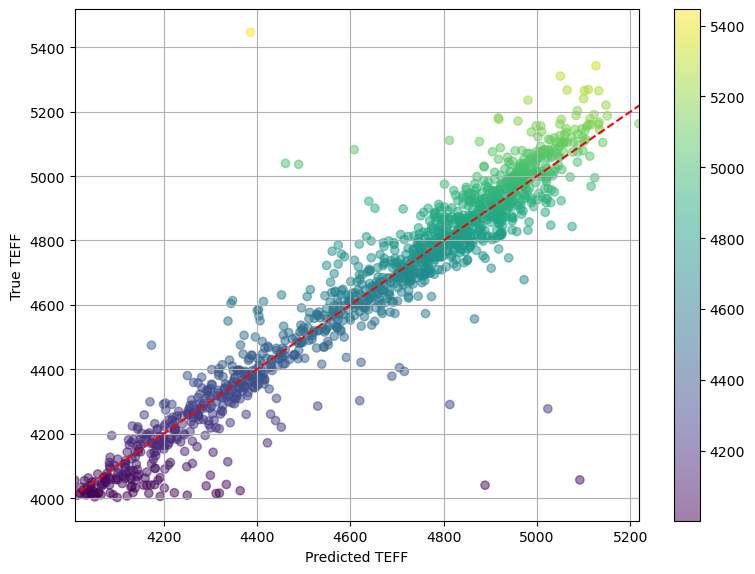

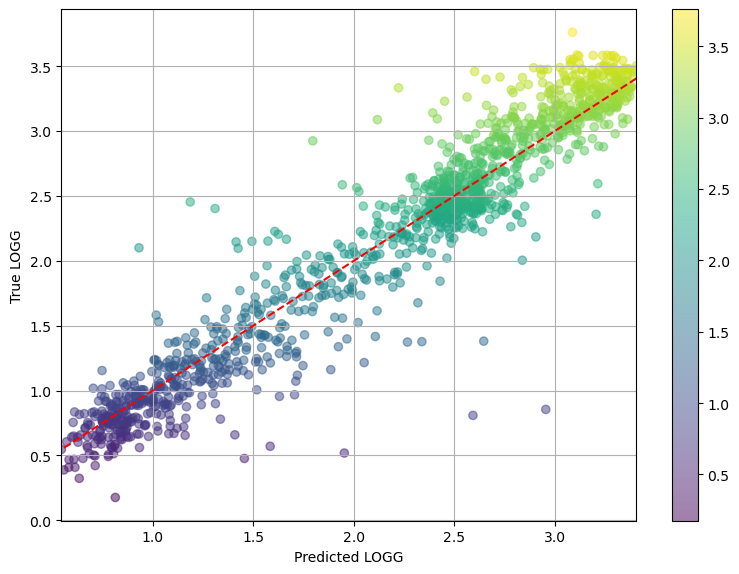

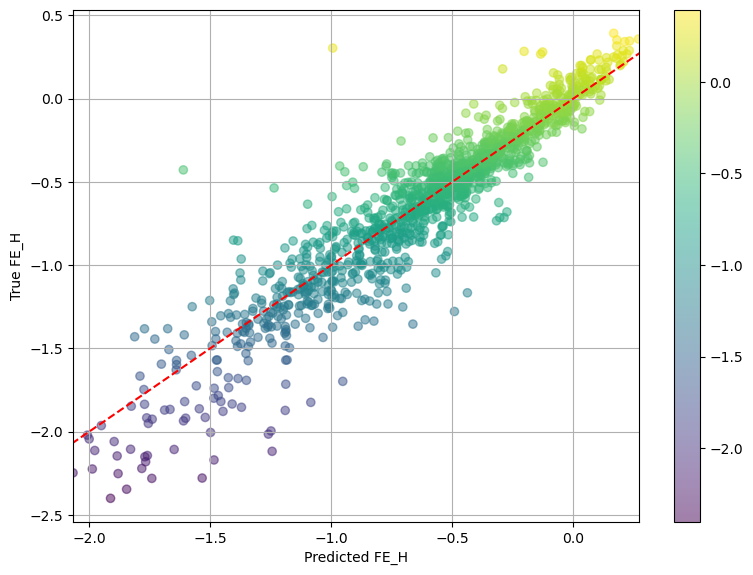

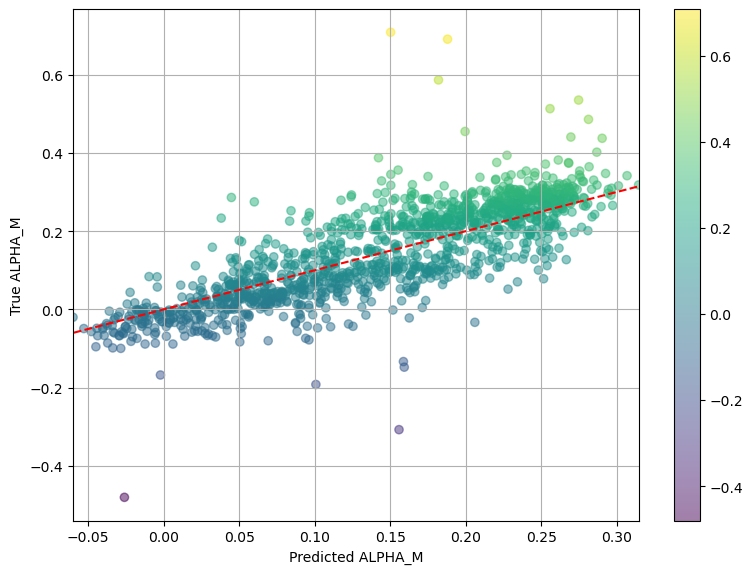

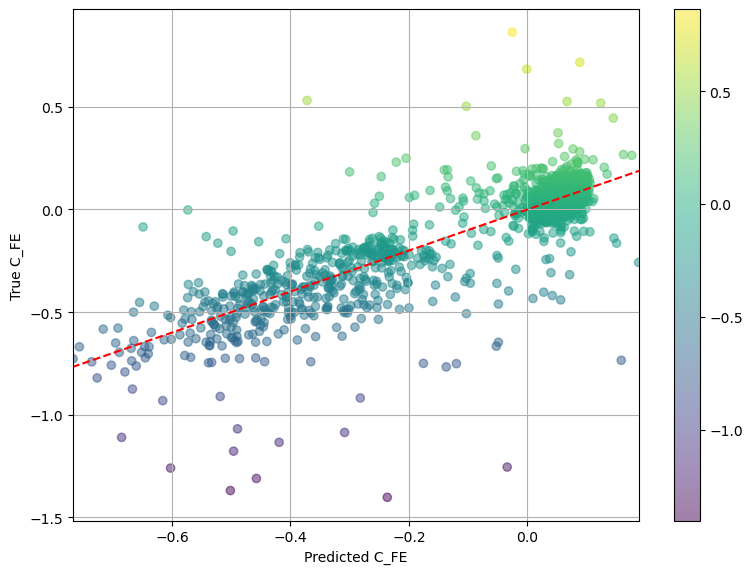

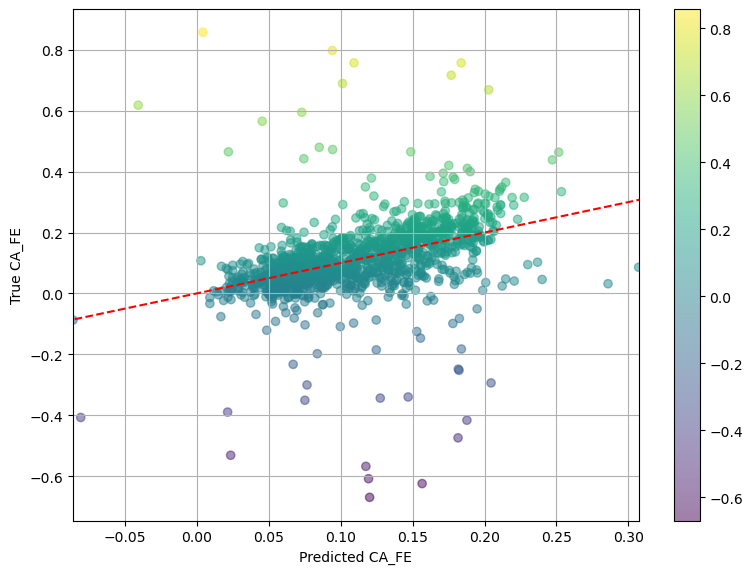

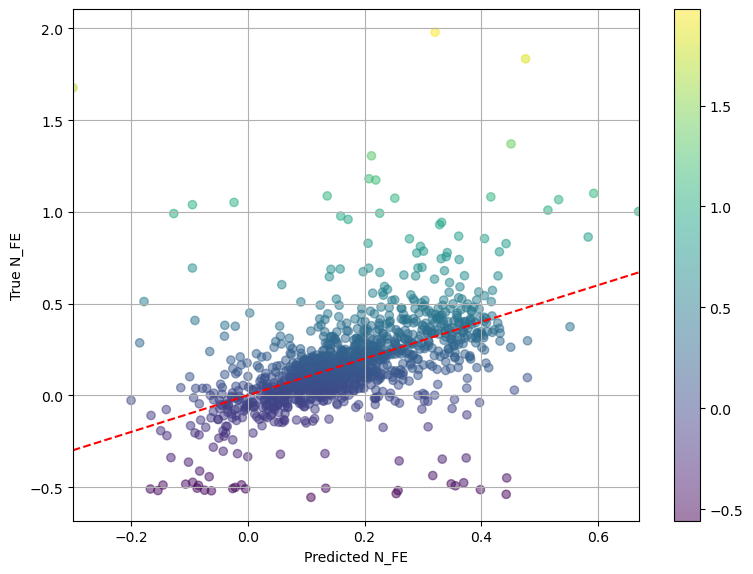

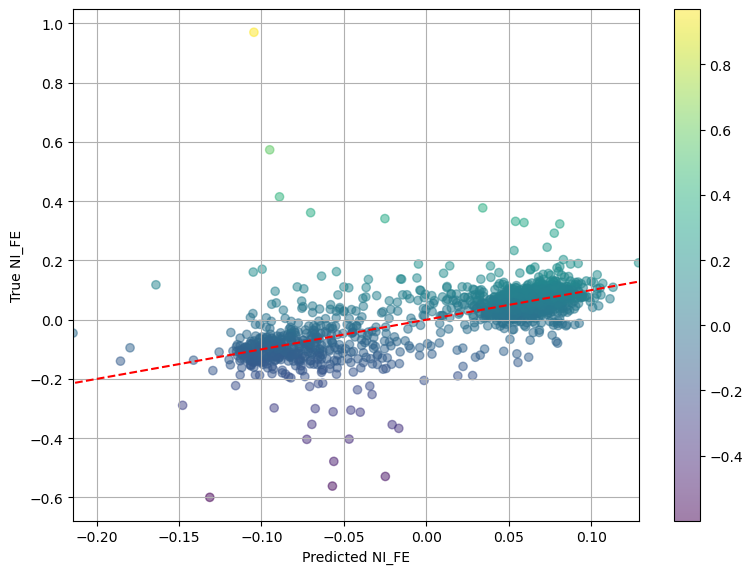

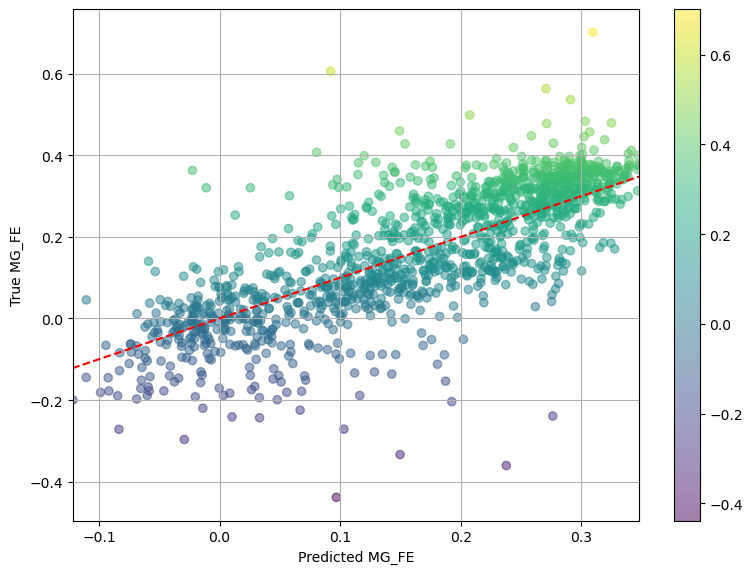

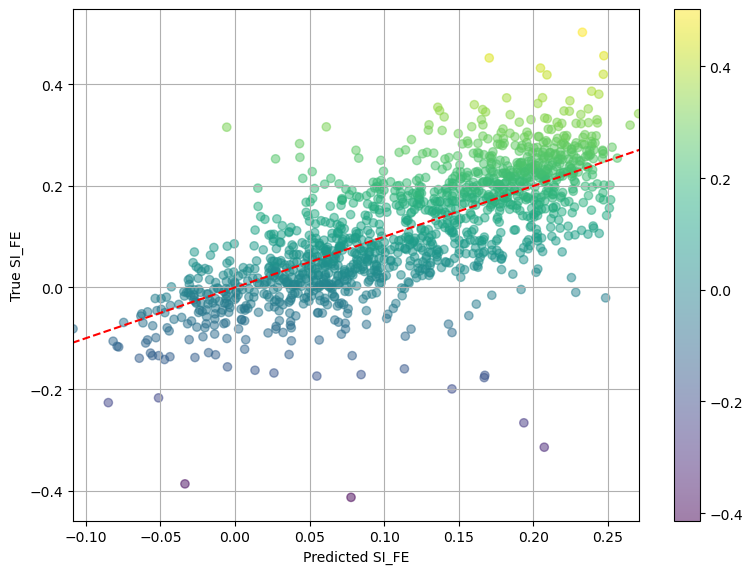

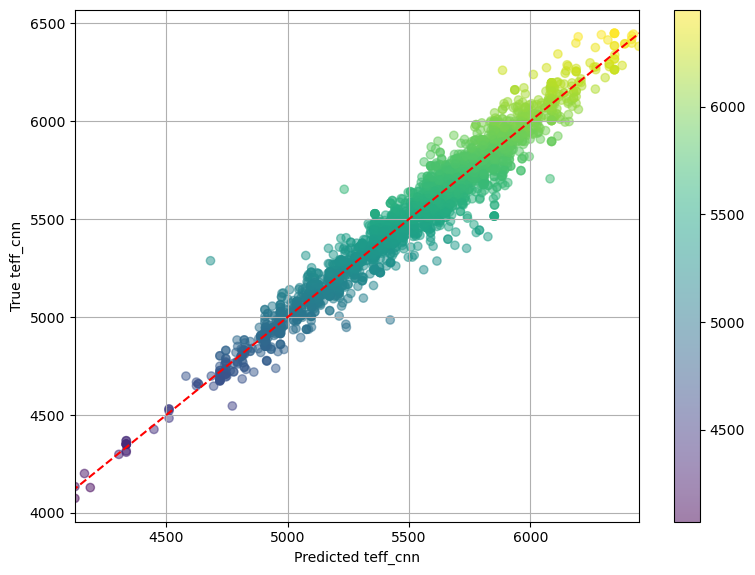

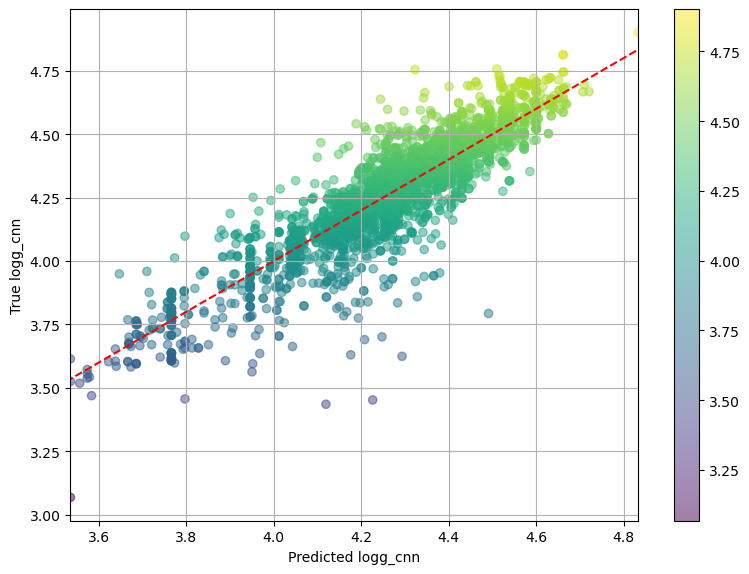

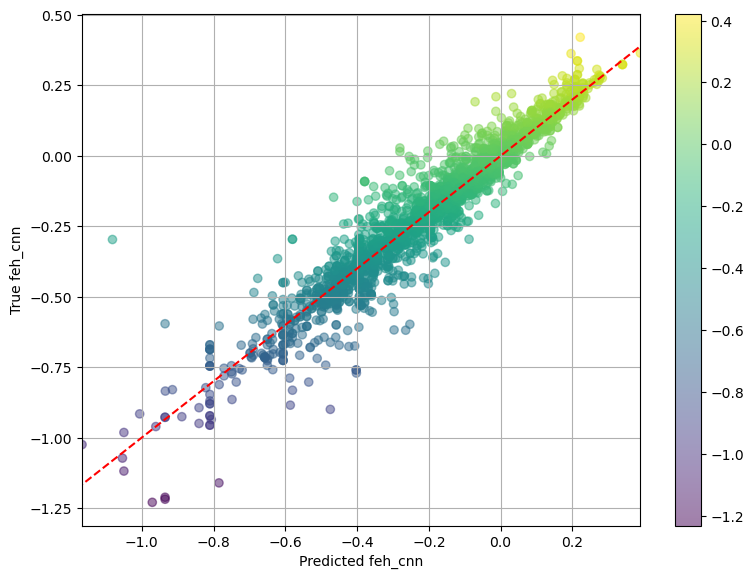

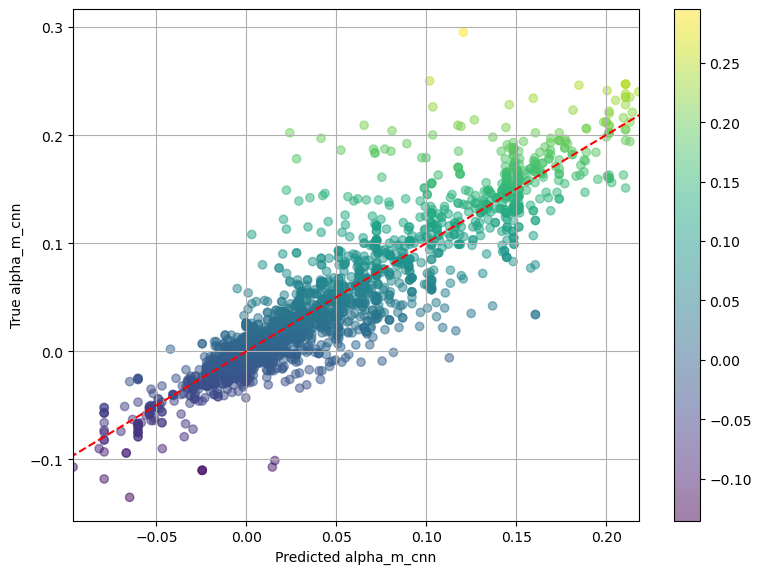

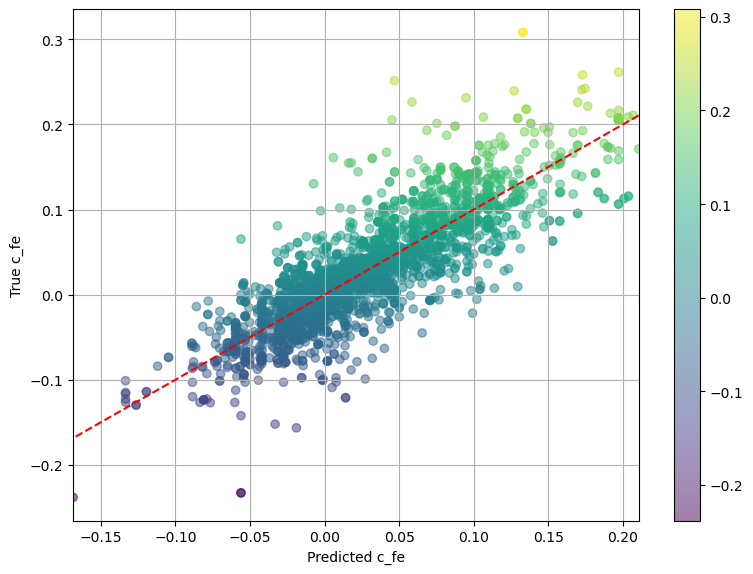

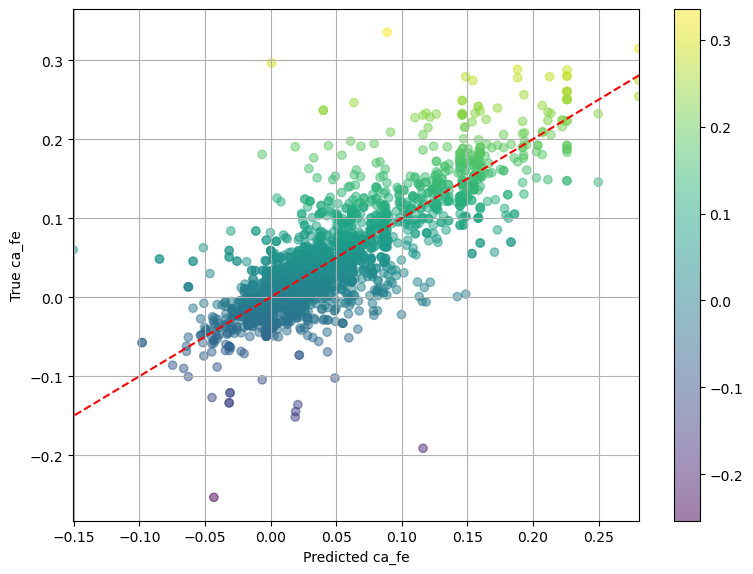

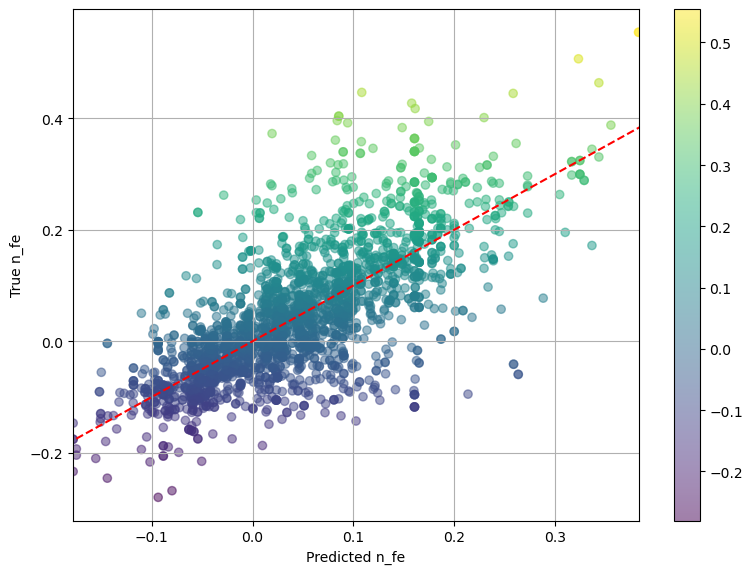

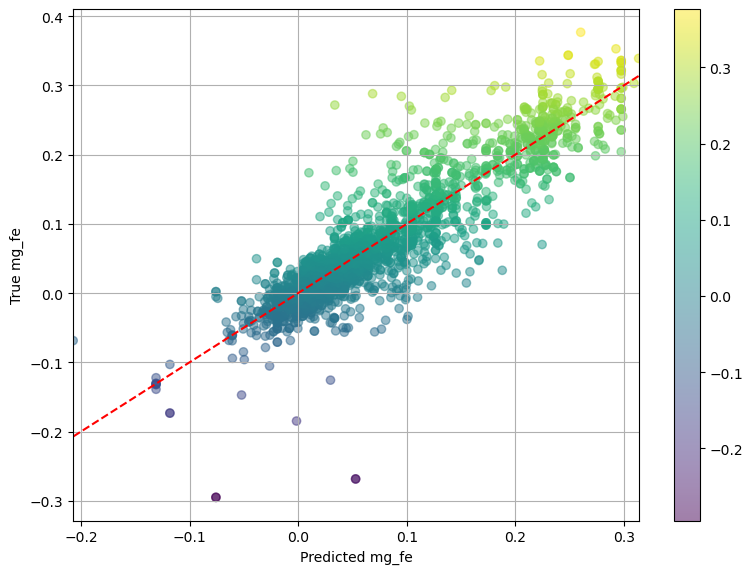

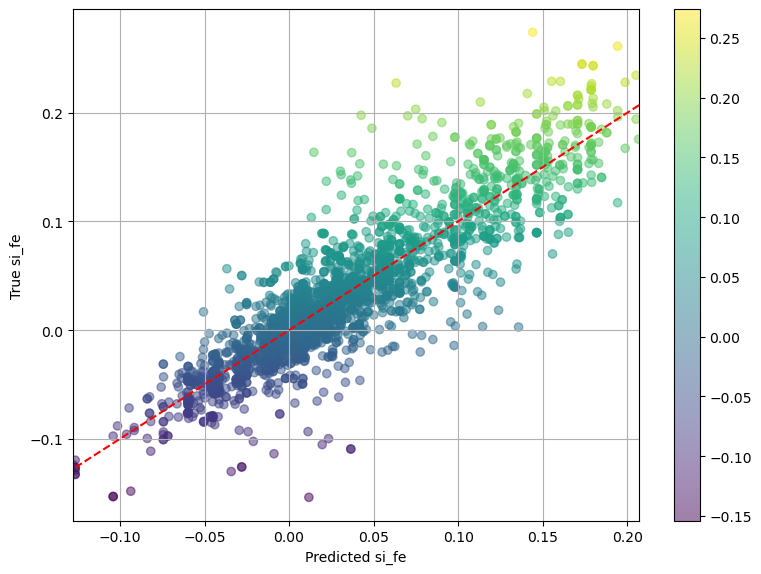

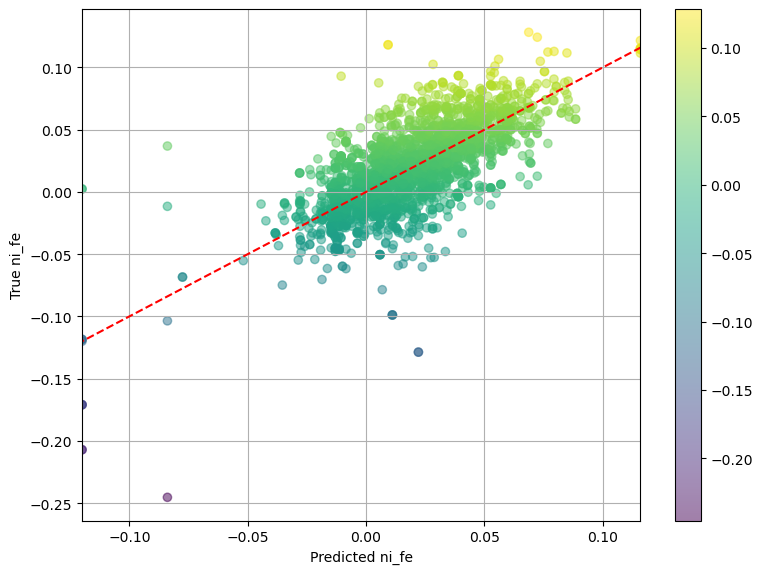

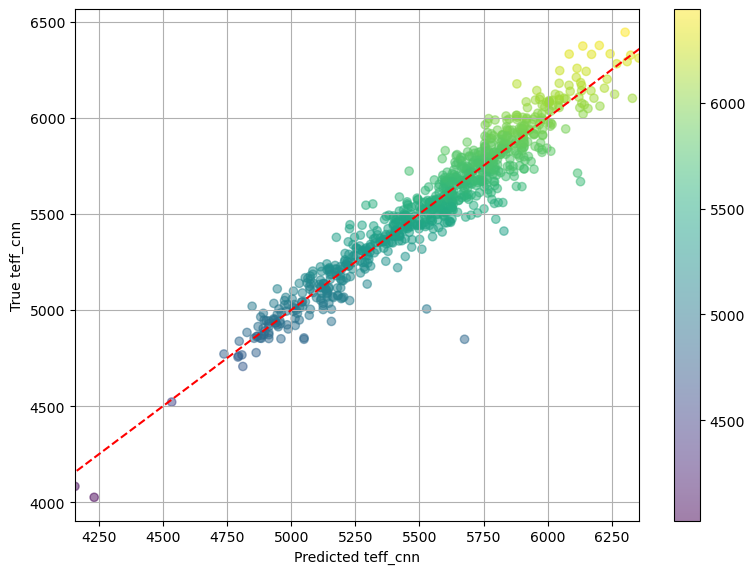

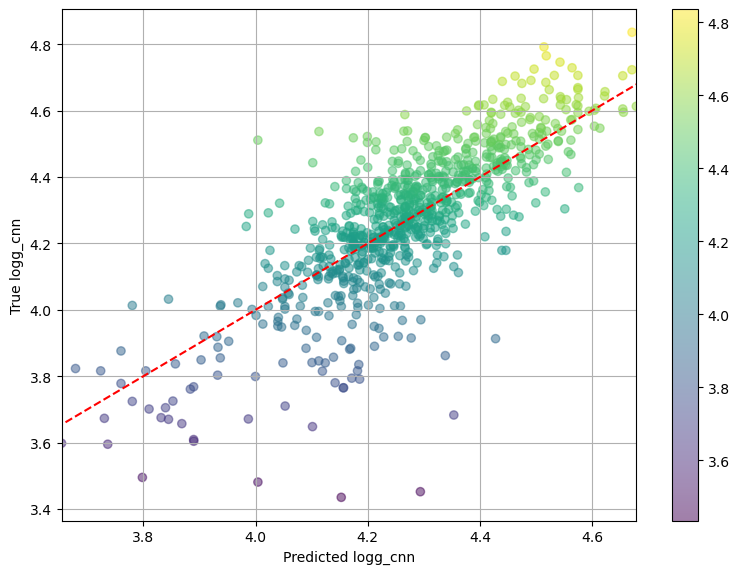

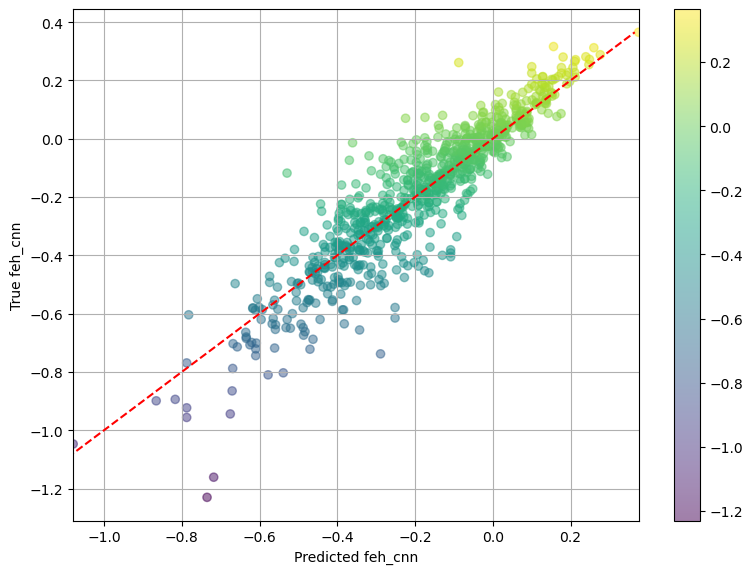

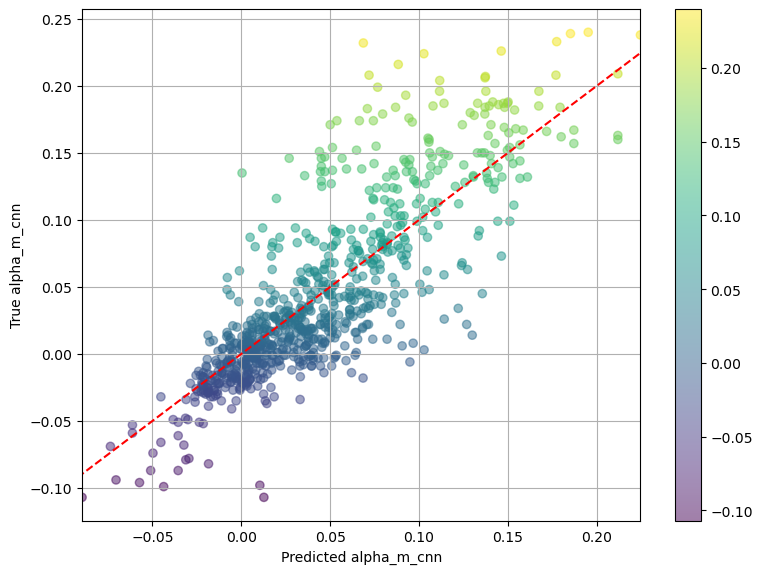

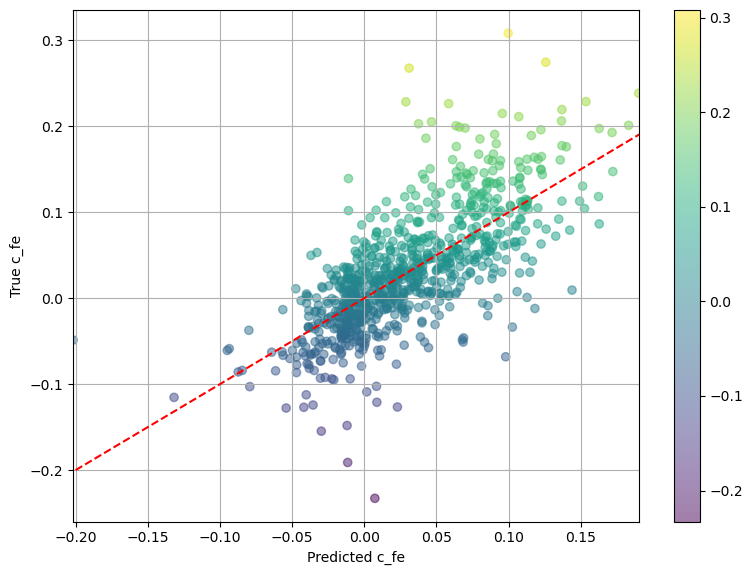

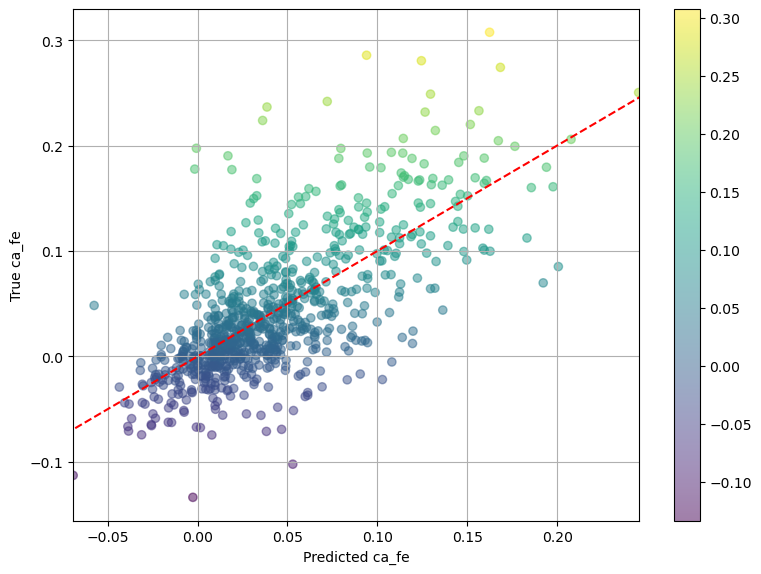

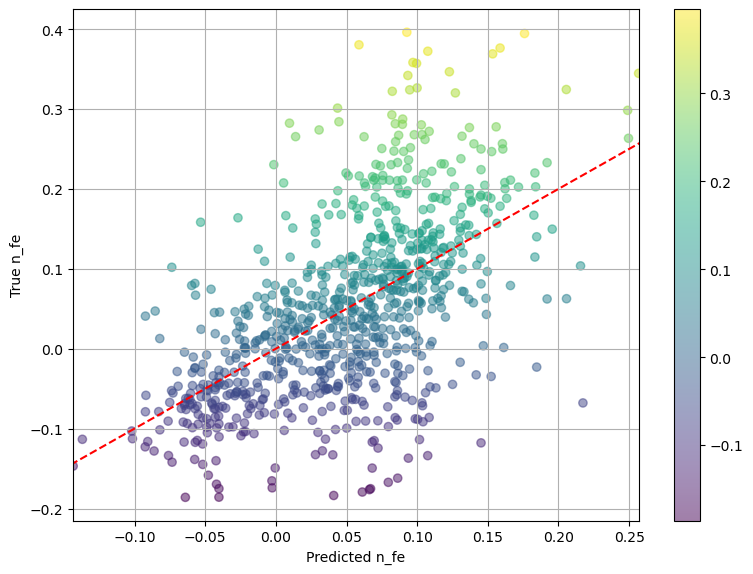

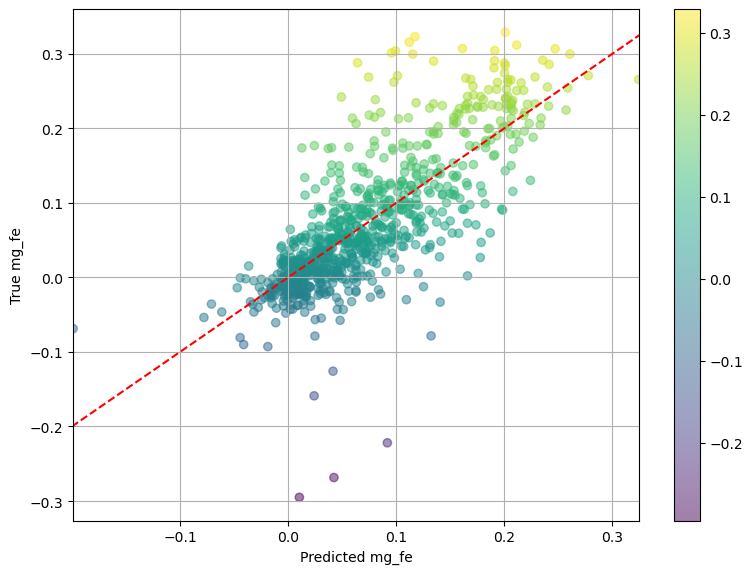

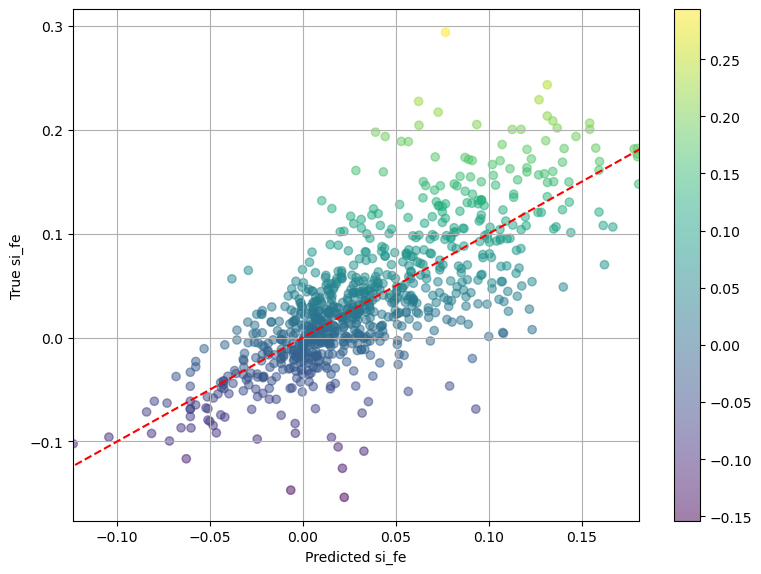

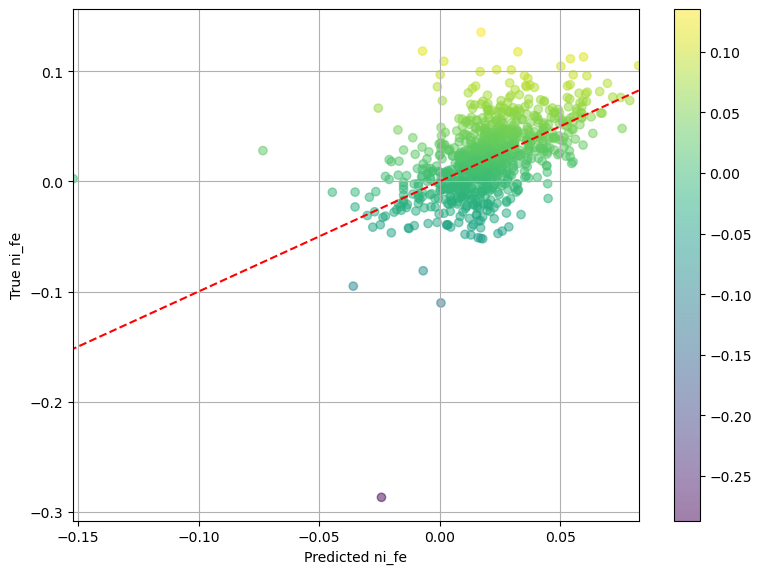

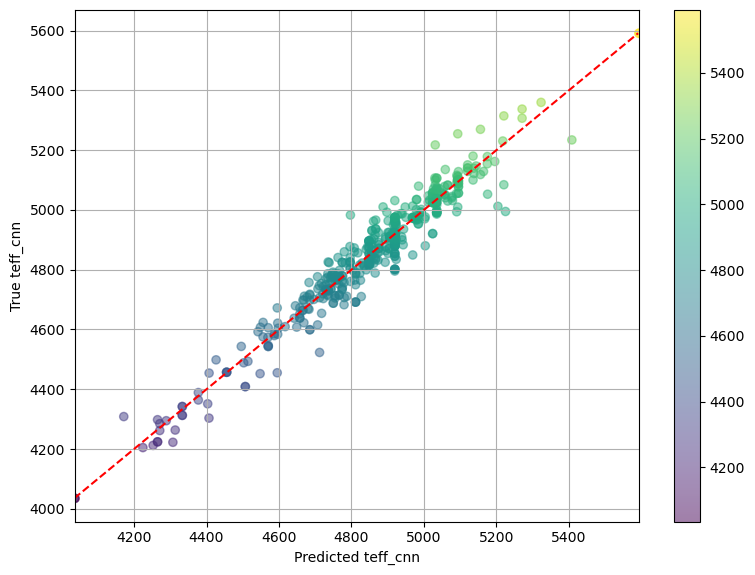

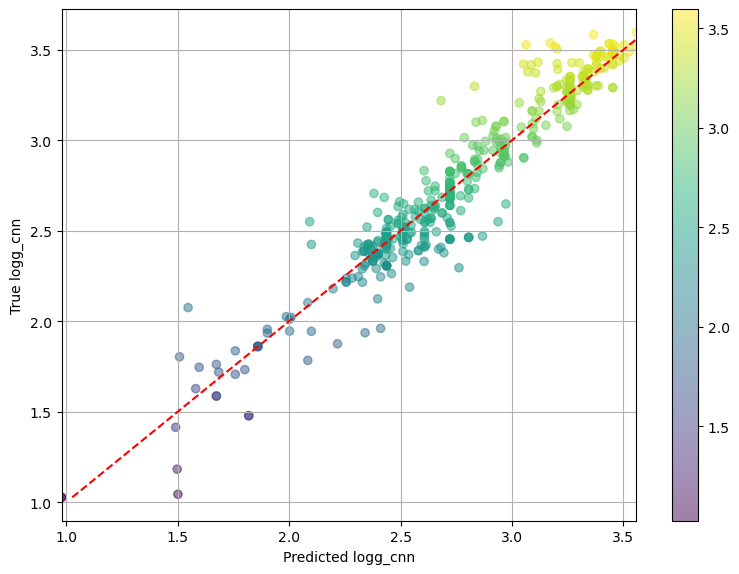

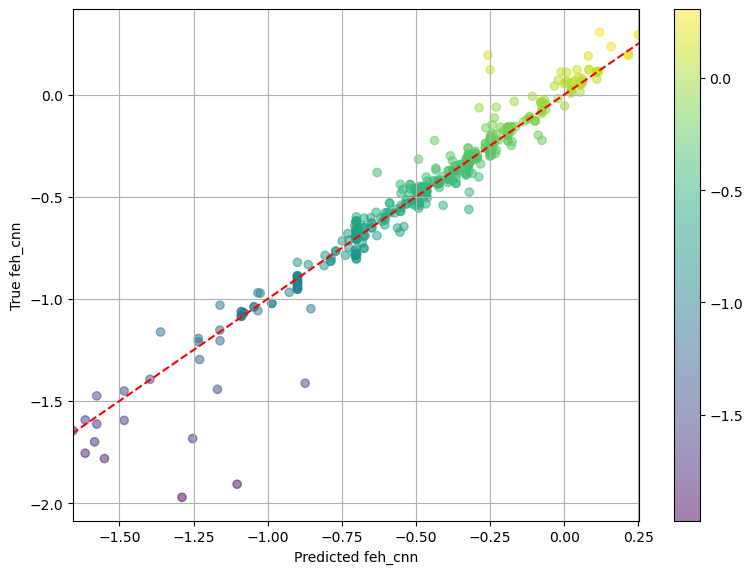

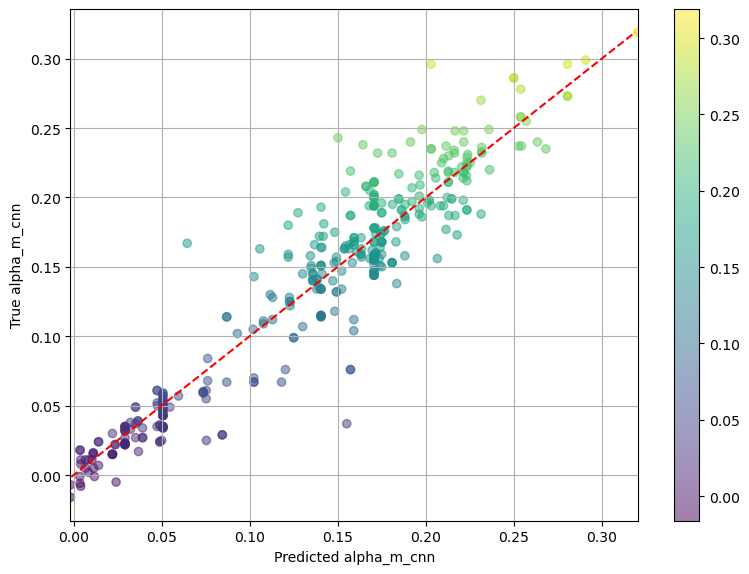

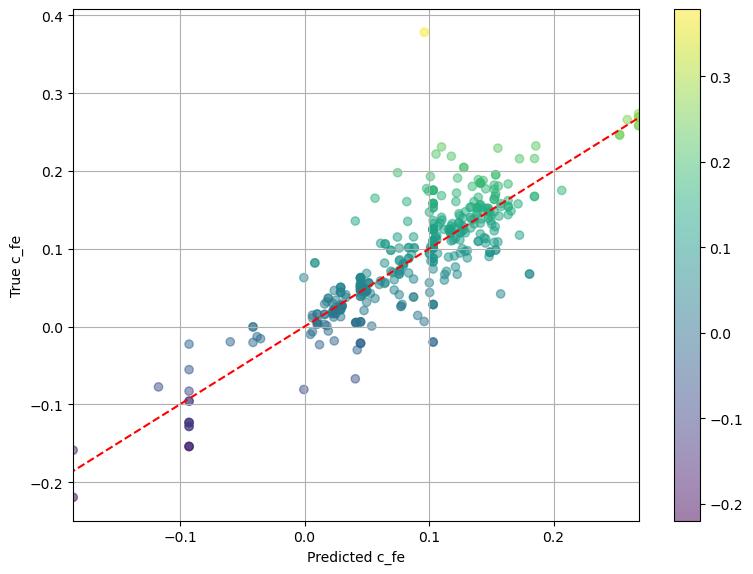

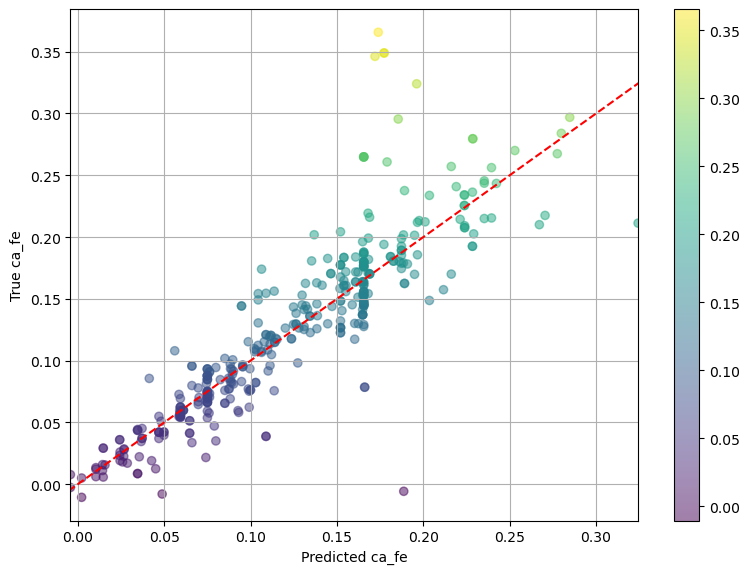

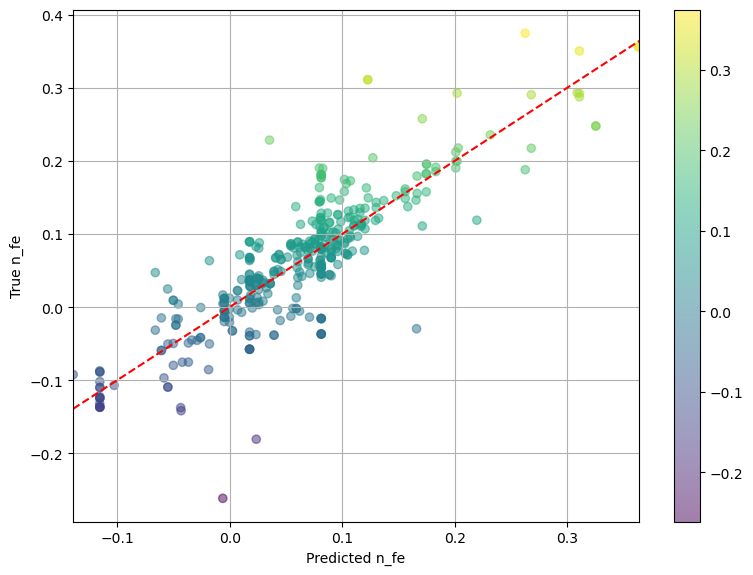

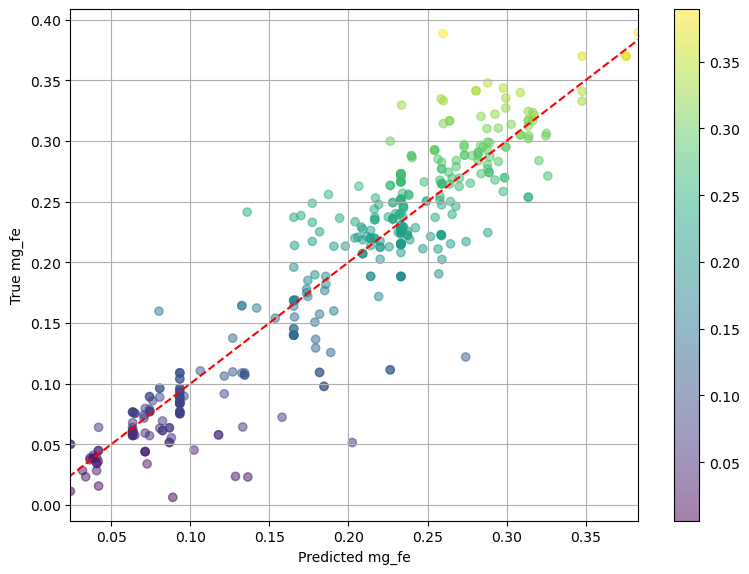

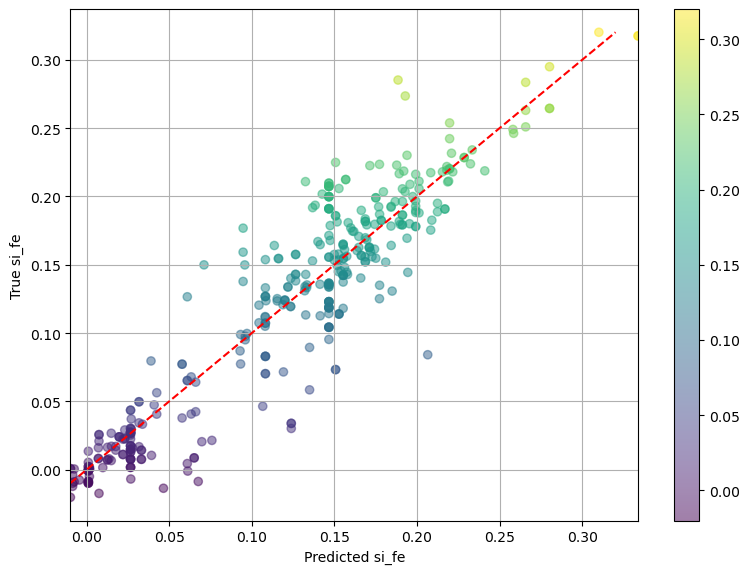

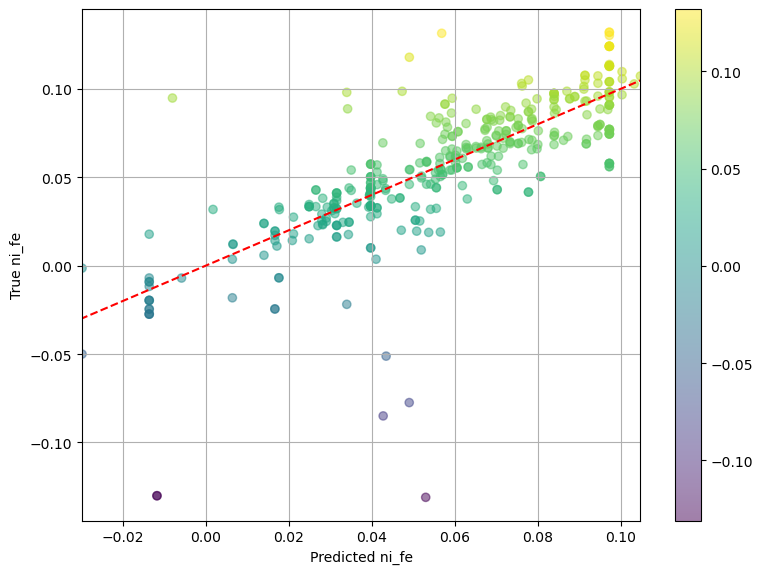

[CV] END ..max_depth=20, max_features=log2, n_estimators=500; total time=   8.1s
[CV] END ..max_depth=30, max_features=log2, n_estimators=200; total time=   3.4s
[CV] END ..max_depth=30, max_features=log2, n_estimators=800; total time=  13.6s
[CV] END ..max_depth=10, max_features=sqrt, n_estimators=500; total time=   5.9s
[CV] END ..max_depth=20, max_features=log2, n_estimators=200; total time=   2.8s
[CV] END ..max_depth=20, max_features=log2, n_estimators=800; total time=  11.6s
[CV] END max_depth=None, max_features=sqrt, n_estimators=500; total time=   8.7s
[CV] END ..max_depth=10, max_features=sqrt, n_estimators=200; total time=   2.3s
[CV] END ..max_depth=20, max_features=sqrt, n_estimators=200; total time=   3.2s
[CV] END ..max_depth=20, max_features=log2, n_estimators=200; total time=   3.0s
[CV] END ..max_depth=20, max_features=log2, n_estimators=500; total time=   7.5s
[CV] END ..max_depth=30, max_features=log2, n_estimators=500; total time=   7.7s
[CV] END max_depth=None, max

In [105]:
for i in file_names:
    test = i
    df_original = pd.read_csv(f'/home/marcelo/nico/data_Splus_parameters/Filtered_Training_Set/{test}.csv')    
    df_original = preprocess_features(df_original,df_original.iloc[:, 1:67].columns,999)
    df_original = preprocess_features(df_original,df_original.iloc[:, 1:67].columns,9999)
    df_original = preprocess_features(df_original,df_original.iloc[:, 1:67].columns,0)
    for j in df_original.columns[67:]:
        test = test + '_' + str(j)
        AnasCores = df_original.copy(deep=True)
        x_columns = list(AnasCores.iloc[:, 1:67].columns)
        y_column = [j]
        AnasCores = preprocess_features(AnasCores,AnasCores[x_columns+y_column].columns,999)
        AnasCores = preprocess_features(AnasCores,AnasCores[x_columns+y_column].columns,9999)
        AnasCores = preprocess_features(AnasCores,AnasCores[x_columns+y_column].columns,0)
        xtrain = AnasCores[x_columns]
        ytrain = AnasCores[j]
        X_train, X_test, Y_train, Y_test = train_test_split(xtrain, ytrain, test_size=0.2, random_state=11085)
        grid_search = optimize_hyperparameters(X_train,Y_train)
        best_params, best_score = grid_search.best_params_, grid_search.best_score_
        pd.DataFrame([best_params]).to_csv(f'/home/marcelo/nico/data_Splus_parameters/result/best_param_{test}.csv',index=False)
        rf_regressor = RandomForestRegressor(**best_params)
        rf_regressor.fit(X_train, Y_train)
        filename = f'/home/marcelo/nico/data_Splus_parameters/result/{test}.sav'
        joblib.dump(rf_regressor, filename)
        #rf_regressor = joblib.load(filename) this is to load the random forest model
        y_pred = rf_regressor.predict(X_test)
        metalicidad = AnasCores.loc[Y_test.index][y_column]
        y_pred_df = pd.DataFrame(y_pred, columns=y_column)
        plot_regression_results(Y_test, y_pred_df,metalicidad,test)

In [112]:
df = pd.read_csv('/home/marcelo/nico/data_Splus_parameters/result/RF_files.txt',names=['files'])

In [119]:
for i in df['files']:
    print(i)

Apogee-Colors-Dwarfs_ALPHA_M.sav
Apogee-Colors-Dwarfs_Apogee-Colors-Dwarfs_TEFF.sav
Apogee-Colors-Dwarfs_CA_FE.sav
Apogee-Colors-Dwarfs_C_FE.sav
Apogee-Colors-Dwarfs_FE_H.sav
Apogee-Colors-Dwarfs_MG_FE.sav
Apogee-Colors-Dwarfs_N_FE.sav
Apogee-Colors-Dwarfs_NI_FE.sav
Apogee-Colors-Dwarfs_SI_FE.sav
Apogee-Colors-Dwarfs_TEFF_LOGG.sav
Apogee-Colors-Giants_ALPHA_M.sav
Apogee-Colors-Giants_CA_FE.sav
Apogee-Colors-Giants_C_FE.sav
Apogee-Colors-Giants_FE_H.sav
Apogee-Colors-Giants_MG_FE.sav
Apogee-Colors-Giants_N_FE.sav
Apogee-Colors-Giants_NI_FE.sav
Apogee-Colors-Giants_SI_FE.sav
Apogee-Colors-Giants_TEFF_LOGG.sav
Galah-Colors-Dwarfs_ca_fe.sav
Galah-Colors-Dwarfs_c_fe.sav
Galah-Colors-Dwarfs_feh_cnn.sav
Galah-Colors-Dwarfs_logg_cnn.sav
Galah-Colors-Dwarfs_m_cnn.sav
Galah-Colors-Dwarfs_mg_fe.sav
Galah-Colors-Dwarfs_n_fe.sav
Galah-Colors-Dwarfs_ni_fe.sav
Galah-Colors-Dwarfs_si_fe.sav
Galah-Colors-Dwarfs_teff_cnn.sav
Galah-Colors-Giants_ca_fe.sav
Galah-Colors-Giants_c_fe.sav
Galah-Colors-Giants_

In [136]:
test

'LamostMedium-Colors-Giants_teff_cnn_logg_cnn_feh_cnn_alpha_m_cnn_c_fe_ca_fe_n_fe_mg_fe_si_fe_ni_fe'

In [134]:
pd.read_csv('/home/marcelo/nico/SplusData/short_splusAll_9Filters_modified.csv')

splus_oid                  #Field          Ra        Dec  IDRef  \
0                 1    HYDRA-0011_000000005  150.194977 -24.592108     10   
1                 2    HYDRA-0011_000000030  150.183609 -24.589680     10   
2                 3    HYDRA-0011_000000042  149.957794 -24.588993     10   
3                 4    HYDRA-0011_000000045  149.967041 -24.591400     10   
4                 5    HYDRA-0011_000000049  150.534393 -24.589628     10   
...             ...                     ...         ...        ...    ...   
11219823   11219824  SPLUS-s46s40_000019479  341.906708 -59.911304   1210   
11219824   11219825  SPLUS-s46s40_000019781  341.161926 -58.965340   1210   
11219825   11219826  SPLUS-s46s40_000019820  341.899689 -58.876694   1210   
11219826   11219827  SPLUS-s46s40_000019887  340.503815 -59.253468   1210   
11219827   11219828  SPLUS-s46s40_000020739  340.976440 -59.945782   1210   

          NMG  mag_psf_u  mag_psf_J0378  mag_psf_J0395  mag_psf_J0410  \
0          10   20.43267     -999.00000       19.86467     -999.00000   
1          12   19.62538       19.36938       19.54638       18.92646   
2          12   18.95029       18.81129       18.74629       18.15370   
3          12   18.46829       18.61929       18.23829       17.55570   
4          12   18.15267       18.06767       17.77167       17.22967   
...       ...        ...            ...            ...            ...   
11219823   10   15.74330       15.52730       15.25730       14.38172   
11219824   10   14.99280       14.76880       14.44680       13.80987   
11219825   11   19.65516       19.25016       19.11016       18.78703   
11219826   10   17.64677       17.08577       16.64877       16.05146   
11219827   10   15.87398       15.69498       15.39098       14.49731   

          mag_psf_J0430  mag_psf_g  mag_psf_J0515  mag_psf_r  mag_psf_J0660  \
0              20.06167   19.76667       19.71667   19.36067       19.40067   
1              18.67946   18.40346       18.29846   17.85970       17.80078   
2              17.99870   17.72670       17.52570   17.24526       17.20626   
3              17.15270   17.94070       16.33870   15.78526       15.68526   
4              17.13467   17.68667       16.50867   16.20967       17.48467   
...                 ...        ...            ...        ...            ...   
11219823       14.13672   13.45872       13.38272   12.58063       12.46463   
11219824       13.64087   13.09306       12.92106   12.42387       12.35689   
11219825       18.71903   18.49103       18.29703   18.00562       17.96862   
11219826       15.99846   14.74746       14.45846   13.46394       12.99294   
11219827       14.25331   13.52231       13.45831   12.61211       12.50011   

          mag_psf_i  mag_psf_J0861  mag_psf_z  
0          19.24467       19.31167   19.18367  
1          17.67080       17.62093   17.59193  
2          17.11527       17.10416   17.13216  
3          15.55027       15.53916   15.50316  
4          17.19217       15.96467   15.90867  
...             ...            ...        ...  
11219823 -999.00000       12.15818 -999.00000  
11219824 -999.00000       12.13903 -999.00000  
11219825   17.87928       17.87840 -999.00000  
11219826 -999.00000       11.52252 -999.00000  
11219827 -999.00000       12.19845 -999.00000  

[11219828 rows x 18 columns]

In [120]:
modelo_rf = joblib.load(f'/home/marcelo/nico/data_Splus_parameters/result/{i}')

In [121]:
modelo_rf

RandomForestRegressor(max_features='log2', n_estimators=200)